In [3]:
pwd = '/nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/'

In [4]:
# Imports necessary utilities and modules

import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

# Graph/histo utilities from ROOT
# Contained within the delayed_jet_analyzer repository
import sys
sys.path.append(pwd+'lib')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

# Used for extracting the TTree structure from each datafile
import os
import uproot

# Sets display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Imports jet clustering algorithm (FastJet)
from pyjet import cluster

donotdelete = []

In [17]:
# Setups dictionaries for storing data from MC/data ntuples
fpath = {}
tree = {}
NEvents = {}

data_path = pwd+'data/'

# Background Samples

# ggH-comparable background: QCD
fpath['qcd'] = data_path +'jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'

# Currently not needed for the analysis
# # Small subset of B samples for quick runs/tests
fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018B_112_dec.root'
# # Complete set of A and B ZeroBias samples (time-intensive to run)
# fpath['zeroBias'] = data_path + 'jet_timing_studies_ZeroBias_Run2018AB_complete.root'

# WH-comparable background: WJetsToLNu
# # Small subset of WJetstoLNu (run interactively on jet_timing_studies)
# fpath['WJetsToLNu'] = data_path + 'jet_timing_studies_ntuple_RunIIFall17DRPremix_WJetsToLNu_TuneCP5_13TeV_setQ5_1.root'

# # Complete set run via CRAB on llp_ntupler
# fpath['WJetsToLNu'] = data_path + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.root'

# # Small subset of WJetstoLNu (run interactively on jet_timing_studies)
# fpath['WJetsToLNu'] = data_path + 'jet_timing_studies_ntuple_WJetsToLNu_inclusive_punch_test.root'
fpath['WJetsToLNu'] = data_path + 'jet_timing_studies_ntuple_WJetsToLNu_inclusiveNLO_bkgRej_test.root'


################################################################

# Signal Samples

# WH: bbbb
# mH = 125 GeV, mX = 15 GeV, ctau = 10 m
fpath['m15ct10000mm'] = data_path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-15_ctauS-10000_TuneCUETP8M1_13TeV.root'

# mH = 125 GeV, mX = 40 GeV, ctau = 10 m
fpath['m40ct10000mm'] = data_path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV.root'

# mH = 125 GeV, mX = 55 GeV, ctau = 10 m, Wminus
# fpath['m55ct10000mm_minus'] = data_path + 'WminusH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV.root'
fpath['m55ct10000mm_minus'] = data_path + 'jet_timing_studies_ntuple_WMinus_mX55ct10m_jetMatch_test.root'

# mH = 125 GeV, mX = 55 GeV, ctau = 10 m, Wplus
# fpath['m55ct10000mm_plus'] = data_path + 'WplusH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV.root'
fpath['m55ct10000mm_plus'] = data_path + 'jet_timing_studies_ntuple_Wplus_mX55ct10m_jetMatch_test.root'


# # WH: MET+bb
# # mH = 125 GeV, mX = 50 GeV, ctau = 1 m
# fpath['m50ct1000mm'] = data_path + 'ntuple_RunIISummer16_bbmet_vh_mh125_mx50_pl1000.root'

# # mH = 125 GeV, mX = 50 GeV, ctau = 10 m
# fpath['m50ct10000mm'] = data_path+'ntuple_RunIISummer16_bbmet_vh_mh125_mx50_pl10000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
# fpath['m975ct1000mm'] = data_path+'ntuple_RunIISummer16_bbmet_vh_mh2000_mx975_pl1000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
# fpath['m975ct10000mm'] = data_path+'ntuple_RunIISummer16_bbmet_vh_mh2000_mx975_pl10000.root'

# ggH
# mH = 125 GeV, mX = 50 GeV, ctau = 1 m
fpath['ggH'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root'

# # mH = 125 GeV, mX = 50 GeV, ctau = 10 m
# fpath['m50ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
# fpath['m975ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'

# # mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
# fpath['m975ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'

# Iterates through each file and extracts the ROOT TTree structure from each
for k,v in fpath.items():
    print(str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    print(k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
    # Accesses the array form of the jetPt branch
#     a = tree[k]["jetPt"].array()
#     print(a[:-1][0])

2019-08-18 23:38:32.282949-07:00
qcd /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root
2019-08-18 23:38:33.635303-07:00
zeroBias /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ZeroBias_Run2018B_112_dec.root
2019-08-18 23:38:33.960562-07:00
WJetsToLNu /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_WJetsToLNu_inclusiveNLO_bkgRej_test.root
2019-08-18 23:38:34.145476-07:00
m15ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-15_ctauS-10000_TuneCUETP8M1_13TeV.root
2019-08-18 23:38:34.333439-07:00
m40ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV.root
2019-08-18 23:38:34.521072-07:00
m55ct10000mm_minus /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_WMinu

In [34]:
# Bookkeeping: Defines the TTrees from the read datafiles
# Names displayed in README.md table

# T_m15_ct10 = tree['m15ct10000mm']
T_wjets = tree['WJetsToLNu']
# T_minBias = tree['zeroBias']
# T_m40_ct10 = tree['m40ct10000mm']
T_m55_ct10_minus = tree['m55ct10000mm_minus']
T_m55_ct10_plus = tree['m55ct10000mm_plus']
T_ggH = tree['ggH']
T_zeroBias = tree['zeroBias']
T_qcd = tree['qcd']

# T_wh = tree['wh_m50ct1000mm']
# T_bkg = tree['WJetsToLNu']

In [36]:
# Variable Definitions
# Creates dictionaries for variables to be analyzed
# The dictionaries will contain the variable arrays for each datafile with a relevant key

# Boolean selections
sel_bool = {}

# CSC
nCsc = {}
csc_z = {}
csc_x = {}
csc_y = {}
csc_eta = {}
csc_phi = {}
csc_t = {}
csc_r = {}

# Gen Level
# gLLP_eta = {}
gLLP_r_0 = {}
gLLP_r_1 = {}
gLLP_decay_0 = {}
gLLP_decay_1 = {}

# Reco level
met_pt = {}
eventNum = {}
lumiNum = {}
jet_pt = {}
ele_pt = {}
mu_pt = {}
nJets = {}
nElectrons = {}
nMuons = {}
nRechits_flag = {}

# Reco - jets
jetEta = {}
jetPhi = {}

In [37]:
# Bookkeeping: Creates a dictionary for iterating over all of the datafiles and 
#              converting the relevant branches to numpy arrays
# Names displayed in README.md table

# data_trees = {'m50ct1m': T, 'qcd': T_bkg, 'zeroBias':T_minBias, 'm50ct10m': T_low_ctau10, 'm975ct1m': T_high_ctau1, 'm975ct10m': T_high_ctau10, 'wh_m50ct1m': T_wh, 'WJetsToLNu': T_w_bkg}
# data_trees = {'m15ct10m_wh_bbbb': T_m15_ct10, 'm40ct10m_wh_bbbb': T_m40_ct10, 'm55ct10m_wh_bbbb_minus': T_m55_ct10_minus, 'm55ct10m_wh_bbbb_plus': T_m55_ct10_plus, 'WJetsToLNu': T_wjets}
data_trees = {'m55ct10m_wh_bbbb_minus': T_m55_ct10_minus, 'm55ct10m_wh_bbbb_plus': T_m55_ct10_plus, 'WJetsToLNu': T_wjets, 'ggH':T_ggH, 'zeroBias':T_zeroBias, 'qcd': T_qcd}

In [38]:
# Event Selection

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species, arbor in data_trees.items():
    if 'wh' in species:
        ele_sel = np.logical_and(np.logical_and(np.absolute(arbor['gParticleId'].array()) == 13, np.absolute(arbor['gParticleMotherId'].array()) == 24), arbor['gParticleStatus'].array() == 1)
        mu_sel = np.logical_and(np.logical_and(np.absolute(arbor['gParticleId'].array()) == 11, np.absolute(arbor['gParticleMotherId'].array()) == 24), arbor['gParticleStatus'].array() == 1)
        sel_lepton = []
        time_counter = 0
#         for ev in np.logical_or(ele_sel, mu_sel):
        for ev in ele_sel:
            time_counter += 1
            if (time_counter % 100000) == 0:
                print(str(time_counter) + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
            if ev.any():
                sel_lepton.append(True)
            else:
                sel_lepton.append(False)
                
    if 'wh' not in species:
        sel_lepton = np.ones(len(arbor), dtype=bool)
                
    if 'metbb' in species or 'bbmet' in species:
        gLLP_r_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_decay_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2 + (arbor['gLLP_decay_vertex_z'].array()[:,0])**2)

        sel_dis_0 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
#         sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
#         sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])<695.5)
#         sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])>100)
        
        sel_signal = np.logical_and(sel_dis_1, sel_lepton)
        sel_bool[species] = sel_signal 
        
    if 'bbbb' in species:
        gLLP_r_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_r_1[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,1])**2+(arbor['gLLP_decay_vertex_y'].array()[:,1])**2)

        
        sel_dis_0 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
#         sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
#         sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])<695.5)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])>100)
        
        sel_dis_1 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,1]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,1]) < 1100)
#         sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(arbor['gLLP_eta'].array()[:,1])<2.4)
#         sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(arbor['gLLP_eta'].array()[:,1])>0.9)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(gLLP_r_1[species])<695.5)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(gLLP_r_1[species])>100)
        
        sel_signal = np.logical_or(sel_dis_0, sel_dis_1)
        sel_signal = np.logical_and(sel_signal, sel_lepton)
        sel_bool[species] = sel_signal 
        
    else:
#         sel_bkg = [True if np.any(x > 50) else False for x in arbor['jetPt'].array()]
#         sel_bkg = np.logical_and(sel_bkg, sel_lepton)
#         sel_bool[species] = sel_bkg
        sel_bool[species] = np.ones(len(arbor['nCsc'].array()), dtype=bool)
        
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-19 00:03:30.935329-07:00
m55ct10m_wh_bbbb_minus: 2019-08-19 00:03:31.655775-07:00
m55ct10m_wh_bbbb_plus: 2019-08-19 00:03:32.377475-07:00
WJetsToLNu: 2019-08-19 00:03:32.390014-07:00
ggH: 2019-08-19 00:03:32.393637-07:00
zeroBias: 2019-08-19 00:03:32.492239-07:00
qcd: 2019-08-19 00:03:32.808997-07:00


In [39]:
# Application of event selection to variables

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

csc_r_quad = {}
for species, arbor in data_trees.items():
    # Endcap: CSCs
    nCsc[species] = arbor['nCsc'].array()[sel_bool[species]]
    csc_z[species] = arbor['cscZ'].array()[sel_bool[species]]
    csc_x[species] = arbor['cscX'].array()[sel_bool[species]]
    csc_y[species] = arbor['cscY'].array()[sel_bool[species]]
    csc_t[species] = arbor['cscT'].array()[sel_bool[species]]
    csc_eta[species] = arbor['cscEta'].array()[sel_bool[species]]
    csc_phi[species] = arbor['cscPhi'].array()[sel_bool[species]]
    csc_r_quad[species] = np.array(arbor['cscX'].array()[sel_bool[species]])**2 + np.array(arbor['cscY'].array()[sel_bool[species]])**2
    csc_r[species] = []
    for hit_r in csc_r_quad[species]:
        r_val = np.sqrt(hit_r.astype(float))
        csc_r[species].append(r_val)

    # Reco-level
    eventNum[species] = arbor['eventNum'].array()[sel_bool[species]]
    lumiNum[species] = arbor['lumiNum'].array()[sel_bool[species]]
#     met_pt[species] = arbor['pfMetPt'].array()[sel_bool[species]]
    
    jet_pt[species] = arbor['jetPt'].array()[sel_bool[species]]
#     ele_pt[species] = arbor['elePt'].array()[sel_bool[species]]
#     mu_pt[species] = arbor['muonPt'].array()[sel_bool[species]]
    nJets[species] = arbor['nJets'].array()[sel_bool[species]]
#     nElectrons[species] = arbor['nElectrons'].array()[sel_bool[species]]
#     nMuons[species] = arbor['nMuons'].array()[sel_bool[species]]
#     nRechits_flag[species] = (arbor['cscNRecHits_flag'].array())[sel_bool[species]]

    
    
    jetEta[species] = arbor['jetEta'].array()[sel_bool[species]]
    jetPhi[species] = arbor['jetPhi'].array()[sel_bool[species]]
    
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-19 00:03:44.006614-07:00
m55ct10m_wh_bbbb_minus: 2019-08-19 00:03:44.899910-07:00
m55ct10m_wh_bbbb_plus: 2019-08-19 00:03:45.084060-07:00
WJetsToLNu: 2019-08-19 00:03:47.640169-07:00
ggH: 2019-08-19 00:03:48.264268-07:00
zeroBias: 2019-08-19 00:04:25.220772-07:00
qcd: 2019-08-19 00:04:26.392992-07:00


In [40]:
# # Extracted variables
# lead_jet_pt = {}
# max_jet_pt = {}
# avg_jet_pt = {}

# # lead_mu_pt = {}
# # max_mu_pt = {}
# # avg_mu_pt = {}

# # lead_ele_pt = {}
# # max_ele_pt = {}
# # avg_ele_pt = {}

# for species in data_trees.keys():
#     lead_jet_pt[species] = [x[0] if len(x) else -1 for x in jet_pt[species]]
#     max_jet_pt[species] = [np.max(np.abs(x)) if len(x) else -1 for x in jet_pt[species]]
#     avg_jet_pt[species] = [np.mean(np.abs(x)) if len(x) else -1 for x in jet_pt[species]]
    
# #     lead_mu_pt[species] = [x[0] if len(x) else -1 for x in mu_pt[species]]
# #     max_mu_pt[species] = [np.max(np.abs(x)) if len(x) else -1 for x in mu_pt[species]]
# #     avg_mu_pt[species] = [np.mean(np.abs(x)) if len(x) else -1 for x in mu_pt[species]]
    
# #     lead_ele_pt[species] = [x[0] if len(x) else -1 for x in ele_pt[species]]
# #     max_ele_pt[species] = [np.max(np.abs(x)) if len(x) else -1 for x in ele_pt[species]]
# #     avg_ele_pt[species] = [np.mean(np.abs(x)) if len(x) else -1 for x in ele_pt[species]]
    
#     print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

In [41]:
# Endcap: CSCs
nCsc['m55ct10m_wh_bbbb'] = np.concatenate([nCsc['m55ct10m_wh_bbbb_minus'], nCsc['m55ct10m_wh_bbbb_plus']])
csc_z['m55ct10m_wh_bbbb'] = np.concatenate([csc_z['m55ct10m_wh_bbbb_minus'], csc_z['m55ct10m_wh_bbbb_plus']])
csc_x['m55ct10m_wh_bbbb'] = np.concatenate([csc_x['m55ct10m_wh_bbbb_minus'], csc_x['m55ct10m_wh_bbbb_plus']])
csc_y['m55ct10m_wh_bbbb'] = np.concatenate([csc_y['m55ct10m_wh_bbbb_minus'], csc_y['m55ct10m_wh_bbbb_plus']])
csc_t['m55ct10m_wh_bbbb'] = np.concatenate([csc_t['m55ct10m_wh_bbbb_minus'], csc_t['m55ct10m_wh_bbbb_plus']])
csc_eta['m55ct10m_wh_bbbb'] = np.concatenate([csc_eta['m55ct10m_wh_bbbb_minus'], csc_eta['m55ct10m_wh_bbbb_plus']])
csc_phi['m55ct10m_wh_bbbb'] = np.concatenate([csc_phi['m55ct10m_wh_bbbb_minus'], csc_phi['m55ct10m_wh_bbbb_plus']])
csc_r['m55ct10m_wh_bbbb'] = np.concatenate([csc_r['m55ct10m_wh_bbbb_minus'], csc_r['m55ct10m_wh_bbbb_plus']])


# Reco-level
eventNum['m55ct10m_wh_bbbb'] = np.concatenate([eventNum['m55ct10m_wh_bbbb_minus'], eventNum['m55ct10m_wh_bbbb_plus']])
lumiNum['m55ct10m_wh_bbbb'] = np.concatenate([lumiNum['m55ct10m_wh_bbbb_minus'], lumiNum['m55ct10m_wh_bbbb_plus']])
# met_pt['m55ct10m_wh_bbbb'] = np.concatenate([met_pt['m55ct10m_wh_bbbb_minus'], met_pt['m55ct10m_wh_bbbb_plus']])

jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([jet_pt['m55ct10m_wh_bbbb_minus'], jet_pt['m55ct10m_wh_bbbb_plus']])
# ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([ele_pt['m55ct10m_wh_bbbb_minus'], ele_pt['m55ct10m_wh_bbbb_plus']])
# mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([mu_pt['m55ct10m_wh_bbbb_minus'], mu_pt['m55ct10m_wh_bbbb_plus']])
nJets['m55ct10m_wh_bbbb'] = np.concatenate([nJets['m55ct10m_wh_bbbb_minus'], nJets['m55ct10m_wh_bbbb_plus']])
# nElectrons['m55ct10m_wh_bbbb'] = np.concatenate([nElectrons['m55ct10m_wh_bbbb_minus'], nElectrons['m55ct10m_wh_bbbb_plus']])
# nMuons['m55ct10m_wh_bbbb'] = np.concatenate([nMuons['m55ct10m_wh_bbbb_minus'], nMuons['m55ct10m_wh_bbbb_plus']])
# nRechits_flag['m55ct10m_wh_bbbb'] = np.concatenate([nRechits_flag['m55ct10m_wh_bbbb_minus'], nRechits_flag['m55ct10m_wh_bbbb_plus']])


jetEta['m55ct10m_wh_bbbb'] = np.concatenate([jetEta['m55ct10m_wh_bbbb_minus'], jetEta['m55ct10m_wh_bbbb_plus']])
jetPhi['m55ct10m_wh_bbbb'] = np.concatenate([jetPhi['m55ct10m_wh_bbbb_minus'], jetPhi['m55ct10m_wh_bbbb_plus']])

# Extracted
# lead_jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([lead_jet_pt['m55ct10m_wh_bbbb_minus'], lead_jet_pt['m55ct10m_wh_bbbb_plus']])
# max_jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([max_jet_pt['m55ct10m_wh_bbbb_minus'], max_jet_pt['m55ct10m_wh_bbbb_plus']])
# avg_jet_pt['m55ct10m_wh_bbbb'] = np.concatenate([avg_jet_pt['m55ct10m_wh_bbbb_minus'], avg_jet_pt['m55ct10m_wh_bbbb_plus']])

# lead_mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([lead_mu_pt['m55ct10m_wh_bbbb_minus'], lead_mu_pt['m55ct10m_wh_bbbb_plus']])
# max_mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([max_mu_pt['m55ct10m_wh_bbbb_minus'], max_mu_pt['m55ct10m_wh_bbbb_plus']])
# avg_mu_pt['m55ct10m_wh_bbbb'] = np.concatenate([avg_mu_pt['m55ct10m_wh_bbbb_minus'], avg_mu_pt['m55ct10m_wh_bbbb_plus']])

# lead_ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([lead_ele_pt['m55ct10m_wh_bbbb_minus'], lead_ele_pt['m55ct10m_wh_bbbb_plus']])
# max_ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([max_ele_pt['m55ct10m_wh_bbbb_minus'], max_ele_pt['m55ct10m_wh_bbbb_plus']])
# avg_ele_pt['m55ct10m_wh_bbbb'] = np.concatenate([avg_ele_pt['m55ct10m_wh_bbbb_minus'], avg_ele_pt['m55ct10m_wh_bbbb_plus']])

In [32]:
data_trees_trigger = ['ggH', 'zeroBias', 'qcd']

In [29]:
# # Hit Selection based on Phi Granularity

pg_ncsc = {}
pg_ncsc_noME11 = {}
pg_ncsc_noME112 = {}
pg_ncsc_noME1123 = {}

for species in data_trees_trigger:
    pg_ncsc[species] = []
    pg_ncsc_noME11[species] = []
    pg_ncsc_noME112[species] = []
    pg_ncsc_noME1123[species] = []
    
    for event in range(len(csc_z[species])):
        cscR = np.sqrt(csc_x[species][event]**2+csc_y[species][event]**2)
        cscZ = csc_z[species][event]
        cscPhi = csc_phi[species][event] * (180/np.pi)
        
        pg_me11 = {'sectors':np.zeros(36), 'counter':0}
        pg_me12 = {'sectors':np.zeros(36), 'counter':0}
        pg_me13 = {'sectors':np.zeros(36), 'counter':0}
        pg_me21 = {'sectors':np.zeros(36), 'counter':0}
        pg_me22 = {'sectors':np.zeros(36), 'counter':0}
        pg_me31 = {'sectors':np.zeros(36), 'counter':0}
        pg_me32 = {'sectors':np.zeros(36), 'counter':0}
        pg_me41 = {'sectors':np.zeros(36), 'counter':0}
        pg_me42 = {'sectors':np.zeros(36), 'counter':0}
        
        
        for zIndex in range(len(cscZ)):
            hit_z = np.absolute(cscZ[zIndex])
            hit_phi = cscPhi[zIndex]
            hit_r = cscR[zIndex]
            
            # ME 1/1
            if hit_z > 568 and hit_z < 632:
                index = int((hit_phi+180)/10.0)
                if index == pg_me11['sectors'].size:
                    pg_me11['sectors'][pg_me11['sectors'].size - 1] += 1
                else:
                    pg_me11['sectors'][index] += 1
#             # ME 1/2 and ME 1/3
            if hit_z > 663 and hit_z < 724:
                if hit_r < 465 and hit_r > 275:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me12['sectors'].size:
                        pg_me12['sectors'][pg_me12['sectors'].size - 1] += 1
                    else:
                        pg_me12['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 505.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me13['sectors'].size:
                        pg_me13['sectors'][pg_me13['sectors'].size - 1] += 1
                    else:
                        pg_me13['sectors'][index] += 1
            # ME 2/1 and ME 2/2
            if hit_z > 791 and hit_z < 849.5:
                if hit_r < 345 and hit_r > 138.5:
                    index = int((hit_phi+180)/20.0)
                    if index == pg_me21['sectors'].size:
                        pg_me21['sectors'][pg_me21['sectors'].size - 1] += 1
                    else:
                        pg_me21['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 357.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me22['sectors'].size:
                        pg_me22['sectors'][pg_me22['sectors'].size - 1] += 1
                    else:
                        pg_me22['sectors'][index] += 1                       
            # ME 3/1 and ME 3/2
            if hit_z > 911.5 and hit_z < 970:
                if hit_r < 345 and hit_r > 160.5:
                    index = int((hit_phi+180)/20.0)
                    if index == pg_me31['sectors'].size:
                        pg_me31['sectors'][pg_me31['sectors'].size - 1] += 1
                    else:
                        pg_me31['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 357.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me32['sectors'].size:
                        pg_me32['sectors'][pg_me32['sectors'].size - 1] += 1
                    else:
                        pg_me32['sectors'][index] += 1    
            # ME 4/1 and ME 4/2
            if hit_z > 1002 and hit_z < 1060.5:
                if hit_r < 345 and hit_r > 177.5:
                    index = int((hit_phi+180)/20.0)
                    if index == pg_me41['sectors'].size:
                        pg_me41['sectors'][pg_me41['sectors'].size - 1] += 1
                    else:
                        pg_me41['sectors'][index] += 1
                if hit_r < 695.5 and hit_r > 357.5:
                    index = int((hit_phi+180)/10.0)
                    if index == pg_me42['sectors'].size:
                        pg_me42['sectors'][pg_me42['sectors'].size - 1] += 1
                    else:
                        pg_me42['sectors'][index] += 1
                    
        pg_me11['counter'] += np.count_nonzero(pg_me11['sectors'])
        pg_me12['counter'] += np.count_nonzero(pg_me12['sectors'])
        pg_me13['counter'] += np.count_nonzero(pg_me13['sectors'])
        pg_me21['counter'] += np.count_nonzero(pg_me21['sectors'])
        pg_me22['counter'] += np.count_nonzero(pg_me22['sectors'])
        pg_me31['counter'] += np.count_nonzero(pg_me31['sectors'])
        pg_me32['counter'] += np.count_nonzero(pg_me32['sectors'])
        pg_me41['counter'] += np.count_nonzero(pg_me41['sectors'])
        pg_me42['counter'] += np.count_nonzero(pg_me42['sectors'])
        

        cscSum_inclusive = pg_me11['counter'] + pg_me12['counter'] + pg_me13['counter'] + pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        cscSum_noME11 = pg_me12['counter'] + pg_me13['counter'] + pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        cscSum_noME112 = pg_me13['counter'] + pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        cscSum_noME1123 = pg_me21['counter'] + pg_me22['counter'] + pg_me31['counter'] + pg_me32['counter'] + pg_me41['counter'] + pg_me42['counter']
        
        pg_ncsc[species].append(cscSum_inclusive)
        pg_ncsc_noME11[species].append(cscSum_noME11)
        pg_ncsc_noME112[species].append(cscSum_noME112)
        pg_ncsc_noME1123[species].append(cscSum_noME1123)
        
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

ggH: 2019-08-18 23:42:07.476442-07:00
zeroBias: 2019-08-18 23:54:22.292483-07:00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cPg


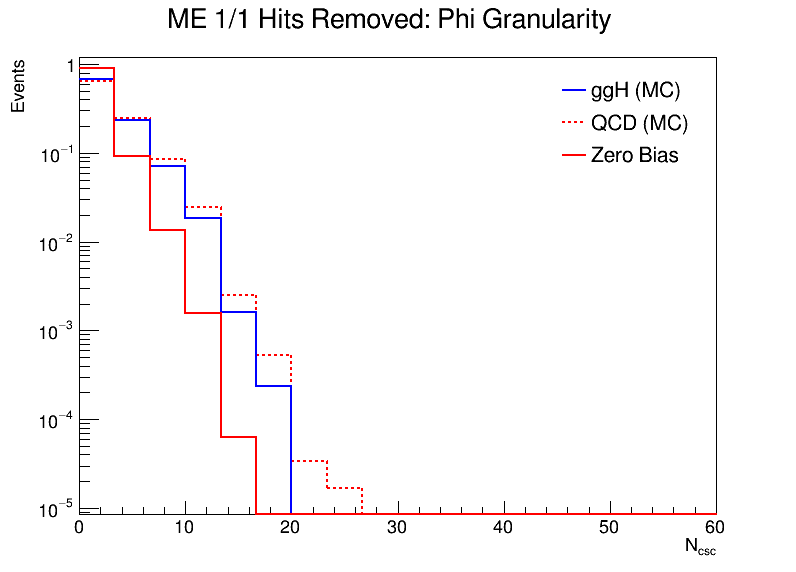

In [43]:
cPg = rt.TCanvas('cPg','cPg', 800, 600)
h={}
h['nCsc_ggH_pg'] = create_TH1D(pg_ncsc_noME11['ggH'], axis_title=['nCsc_ggH', 'Events'], name='nCsc_ggH_pg', binning=[150,0,500])
h['nCsc_ggH_pg'].SetLineColor(4)

h['nCsc_qcd_pg'] = create_TH1D(pg_ncsc_noME11['qcd'], axis_title=['nCsc_qcd', 'Events'], name='nCsc_qcd_pg', binning=[150,0,500])
h['nCsc_qcd_pg'].SetLineColor(2)
h['nCsc_qcd_pg'].SetLineStyle(2)


h['nCsc_zeroBias_pg'] = create_TH1D(pg_ncsc_noME11['zeroBias'], axis_title=['nCsc_zeroBias', 'Events'], name='nCsc_zeroBias_pg', binning=[150,0,500])
h['nCsc_zeroBias_pg'].SetLineColor(2)
h['nCsc_zeroBias_pg'].SetLineStyle(1)

cPg.SetLogy()

h['nCsc_ggH_pg'].Scale(1.0/h['nCsc_ggH_pg'].Integral())
h['nCsc_qcd_pg'].Scale(1.0/h['nCsc_qcd_pg'].Integral())
h['nCsc_zeroBias_pg'].Scale(1.0/h['nCsc_zeroBias_pg'].Integral())


h['nCsc_ggH_pg'].SetLineWidth(2)
h['nCsc_qcd_pg'].SetLineWidth(2)
h['nCsc_zeroBias_pg'].SetLineWidth(2)

h['nCsc_ggH_pg'].GetXaxis().SetRangeUser(0,60)
h['nCsc_qcd_pg'].GetXaxis().SetRangeUser(0,60)
h['nCsc_zeroBias_pg'].GetXaxis().SetRangeUser(0,60)


h['nCsc_qcd_pg'].SetStats(0)
h['nCsc_qcd_pg'].SetTitle("ME 1/1 Hits Removed: Phi Granularity")
h['nCsc_qcd_pg'].SetXTitle("N_{csc}")


h['nCsc_qcd_pg'].Draw('histo')
h['nCsc_ggH_pg'].Draw('histo+same')
h['nCsc_zeroBias_pg'].Draw('histo+same')

legend = rt.TLegend(0.70,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
#legend-.SetFillStyle(0);
legend.AddEntry( h['nCsc_ggH_pg'], "ggH (MC)" , "L");
legend.AddEntry( h['nCsc_qcd_pg'], "QCD (MC)" , "L");
legend.AddEntry( h['nCsc_zeroBias_pg'], "Zero Bias" , "L");

legend.Draw();

cPg.Draw()

In [132]:
print(lumiNum['WJetsToLNu'][(np.where(nCsc['WJetsToLNu']>120)[0])])
print(len(np.where(nCsc['WJetsToLNu']>120)[0]))
print(len(np.where(nCsc['m55ct10m_wh_bbbb']>120)[0]))

[ 13590  29404 197522 117407  63751 114103  49064 196757 110299 170975
  33611 178553 168345 239669 111794 212079  15527 207167  92310  14654]
20
184


In [133]:
# Selection of Events for Event Display Purposes (Test area)

index_ev = np.array(nCsc['WJetsToLNu'])>120
lumi_all = [13586,13590,13591,25734,25735,27532,28003,29402,29403,42260,54797,54801,141079,141082,177719,177720,180211,187259,204793,222504,224562,234012,237872,26588,34811,42263,105430,148389,177717,180213,180216,187258,187260,187263,187264,204015,204016,204017,222502,224561,237870,26589,27531,28004,28007,141080,148391,148392,178213,178214,204791,219240,222544,228252,237871,240623,250722,250724,251836,251839,13587,26587,26590,28005,42257,105431,105432,141081,177721,180215,187261,204014,219241,219242,224559,224560,237869,237876,240620,250723,251838,27529,27530,28001,28002,34964,34965,42258,54795,177718,177723,178215,180209,222503,228250,250725,251837,13588,13592,29405,34963,54800,148390,187262,204792,228249,240621,240622,13585,13589,28000,42256,42262,54794,54796,54798,177716,178216,180212,189225,204790,222505,222541,222542,234014,234015,237873,237875,240619,25733,25736,28006,29404,42259,42261,54799,105429,177722,180210,180214,219243,222543,228251,234013,237874,240618]

# print(nCsc['WJetsToLNu'][np.where(eventNum['WJetsToLNu']==34136610)])
# print(np.array(nCsc_station['WJetsToLNu']['ME_12'])[np.where(eventNum['WJetsToLNu']==34136610)])

# print(np.array(nCsc_jetMatch['WJetsToLNu'])[np.where(eventNum['WJetsToLNu']==34136610)])


ncsc_event_sel = nCsc['WJetsToLNu'][index_ev][np.isin(np.array(lumiNum['WJetsToLNu'][index_ev]), lumi_all)]
evNum_event_sel = eventNum['WJetsToLNu'][index_ev][np.isin(np.array(lumiNum['WJetsToLNu'][index_ev]), lumi_all)]
lumiNum_event_sel = lumiNum['WJetsToLNu'][index_ev][np.isin(np.array(lumiNum['WJetsToLNu'][index_ev]), lumi_all)]

print('Lumi ' + 'Event ' + 'nCsc ')
print(np.dstack((lumiNum_event_sel, evNum_event_sel, ncsc_event_sel)))

Lumi Event nCsc 
[[[  13590 3347055     123]
  [  29404 7235093     122]]]


In [134]:
weight_m55ct10m_minus = (5.328 * 10**-1 * 0.324 * 137 * 1000 * 0.1)/NEvents['m55ct10000mm_minus']
# print(weight_m55ct10m_minus)
# print(NEvents['m55ct10000mm_minus'])
weight_m55ct10m_minus = np.full(len(nCsc['m55ct10m_wh_bbbb_minus']), weight_m55ct10m_minus)
# weight_m55ct10m_minus = np.full(int(NEvents['m55ct10000mm_minus']), weight_m55ct10m_minus)


weight_m55ct10m_plus = (8.4 * 10**-1 * 0.324 * 137 * 1000 * 0.1)/NEvents['m55ct10000mm_plus']
# print(weight_m55ct10m_plus)
# print(NEvents['m55ct10000mm_plus'])
weight_m55ct10m_plus = np.full(len(nCsc['m55ct10m_wh_bbbb_plus']), weight_m55ct10m_plus)
# weight_m55ct10m_plus = np.full(int(NEvents['m55ct10000mm_plus']), weight_m55ct10m_plus)

weight_m55ct10m = np.concatenate([weight_m55ct10m_minus, weight_m55ct10m_plus])
print(weight_m55ct10m)

# weight_m15ct10m = (5.328 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m15ct10000mm']
# weight_m15ct10m = np.full(len(nCsc['m15ct10m_wh_bbbb']), weight_m15ct10m)

# weight_m40ct10m = (61526.7 * 137 * 1000)/NEvents['m40ct10000mm']
# weight_m40ct10m = np.full(len(nCsc['m40ct10m_wh_bbbb']), weight_m40ct10m)

weight_WJetsToLNu = (61526.7 * 137 * 1000)/NEvents['WJetsToLNu']
print(weight_WJetsToLNu)
# print(NEvents['WJetsToLNu'])
weight_WJetsToLNu = np.full(len(nCsc['WJetsToLNu']), weight_WJetsToLNu)

[0.09460349 0.09460349 0.09460349 ... 0.14917948 0.14917948 0.14917948]
36487.649666253994


In [135]:
print(len(np.where(nCsc['m55ct10m_wh_bbbb_minus']>150)[0])*0.009460349)
print(len(np.where(nCsc['m55ct10m_wh_bbbb_plus']>150)[0])*0.014917948)
print(len(np.where(nCsc['WJetsToLNu']>150)[0]))

print(len(np.where(nCsc['m55ct10m_wh_bbbb_plus']>150)[0])*0.014917948)
for x in range(200):
    if (len(np.where(nCsc['m55ct10m_wh_bbbb_minus']>x)[0])*0.009460349 + len(np.where(nCsc['m55ct10m_wh_bbbb_plus']>x)[0])*0.014917948) <= 20:
        print(x)
        print((len(np.where(nCsc['m55ct10m_wh_bbbb_minus']>x)[0])*0.009460349 + len(np.where(nCsc['m55ct10m_wh_bbbb_plus']>x)[0])*0.014917948))

0.312191517
0.7608153480000001
4
0.7608153480000001
19
19.996038258
20
19.601982755999998
21
19.201376603
22
18.762567257
23
18.213874676
24
17.86966882
25
17.507997115000002
26
17.092473014
27
16.627830522
28
16.263610915999998
29
16.040203493
30
15.751666679
31
15.363068776
32
15.126198254
33
14.809280393000002
34
14.533113626
35
14.294788255
36
14.048457384
37
13.795214065
38
13.527052798
39
13.261801229
40
12.907041972
41
12.76077219
42
12.563197913
43
12.345248089
44
12.101465119
45
11.896978394
46
11.680483419000002
47
11.444705949
48
11.249679573000002
49
10.972057957
50
10.755562982
51
10.584914903
52
10.455017918
53
10.314205735
54
10.158475604
55
9.920150233000001
56
9.756414602
57
9.587221372
58
9.313602506
59
9.172790323000001
60
9.021062942
61
8.826036565999999
62
8.62700744
63
8.46181696
64
8.270793334
65
8.035015864
66
7.8265263890000005
67
7.6951745549999995
68
7.49068783
69
7.334957699
70
7.187233068
71
7.1046378279999995
72
6.9026990040000005
73
6.805185816
74
6.69275

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


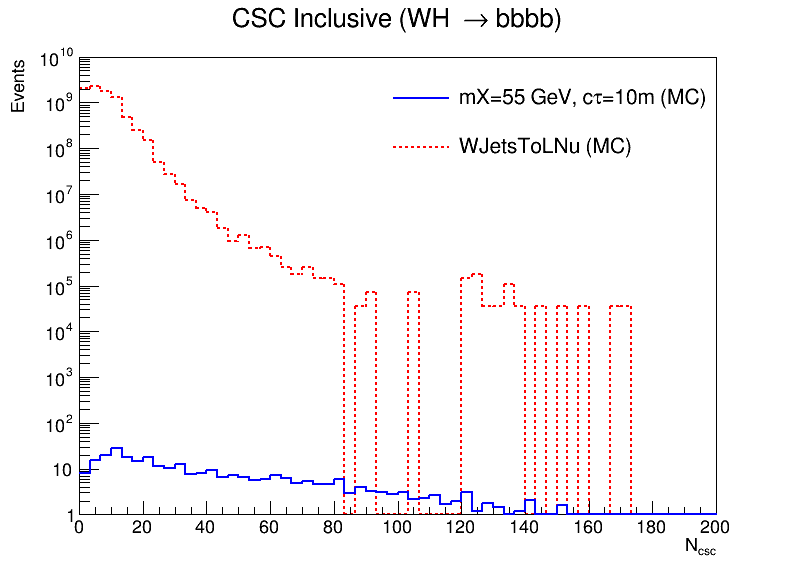

In [136]:
# Creates a 1D histogram of the number of CSC hits for the m50ct1m signal MC, QCD MC, and ZeroBias data 
# with no hit removal

c = rt.TCanvas('c','c', 800, 600)
h = {}
# h['nCsc_m50ct1m'] = create_TH1D(nCsc['m50ct1m'], axis_title=['nCsc_m50ct1m', 'Events'], name='nCsc_m50ct1m', binning=[150,0,500])
# h['nCsc_m50ct1m'].SetLineColor(4)

h['m55ct10m_wh_bbbb'] = create_TH1D(nCsc['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb'].SetLineColor(4)
# h['nCsc_m50ct10m'].SetLineStyle(2)

h['nCsc_wjets'] = create_TH1D(nCsc['WJetsToLNu'], axis_title=['nCsc_wjets', 'Events'], name='nCsc_wjets', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets'].SetLineColor(2)
h['nCsc_wjets'].SetLineStyle(2)


# h['nCsc_zeroBias'] = create_TH1D(nCsc['zeroBias'], axis_title=['nCsc_zeroBias', 'Events'], name='nCsc_zeroBias', binning=[150,0,500])
# h['nCsc_zeroBias'].SetLineColor(2)
# h['nCsc_zeroBias'].SetLineStyle(1)

c.SetLogy()

# h['nCsc_m50ct1m'].Scale(1.0/h['nCsc_m50ct1m'].Integral())
# h['m55ct10m_wh_bbbb'].Scale(1.0/h['m55ct10m_wh_bbbb'].Integral())

# h['nCsc_wjets'].Scale(1.0/h['nCsc_wjets'].Integral())
# h['nCsc_zeroBias'].Scale(1.0/h['nCsc_zeroBias'].Integral())


# h['nCsc_m50ct1m'].SetLineWidth(1)
h['m55ct10m_wh_bbbb'].SetLineWidth(2)

h['nCsc_wjets'].SetLineWidth(2)
# h['nCsc_zeroBias'].SetLineWidth(2)

# h['nCsc_m50ct1m'].GetXaxis().SetRangeUser(0,200)
h['nCsc_wjets'].GetYaxis().SetRangeUser(1,10**10)

h['nCsc_wjets'].GetXaxis().SetRangeUser(0,200)
# h['nCsc_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nCsc_wjets'].SetStats(0)
h['nCsc_wjets'].SetTitle("CSC Inclusive (WH #rightarrow bbbb)")
h['nCsc_wjets'].SetXTitle("N_{csc}")


h['nCsc_wjets'].Draw('histo')
# h['nCsc_m50ct1m'].Draw('histo+same')
h['m55ct10m_wh_bbbb'].Draw('histo+same')
# h['nCsc_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
# legend.SetFillStyle(0);
# legend.AddEntry( h['nCsc_m50ct1m'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
legend.AddEntry( h['nCsc_wjets'], "WJetsToLNu (MC)" , "L");
# legend.AddEntry( h['nCsc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

In [137]:
# Basic Implementation


In [185]:
# Hit Removal
# For both the endcap and barrel regions (overlap to be determined), the closest stations to the beamspot are the noisiest.
# Thus, we remove the hits that land in these stations for each event in each datafile.

# Endcap
nCsc_station = {}
nCsc_removal = {}

# Loops over every datafile
for files in data_trees.keys():
    # Endcap
    nCsc_station[files] = {}
    nCsc_station[files]['ME_11'] = []
    nCsc_station[files]['ME_12'] = []
    nCsc_station[files]['ME_13'] = []
    
    # Loops over every event in each datafile
    for pos_bool in range(len(csc_z[files])):
        csc_r = np.sqrt(csc_x[files][pos_bool]**2+csc_y[files][pos_bool]**2)
        z_pos_bool = csc_z[files][pos_bool]
        
        counter_me11 = 0
        counter_me12 = 0
        counter_me13 = 0
        
        # Loops over every hit in each event
        for z_ind in range(len(z_pos_bool)):
            z_bool = np.absolute(z_pos_bool[z_ind])
            # ME 1/1 Constraints
            if z_bool > 568 and z_bool < 632:
                counter_me11 += 1
                
            if z_bool > 663 and z_bool < 724:
                # ME 1/2 Constraints
                if csc_r[z_ind] < 465 and csc_r[z_ind] > 275:
                    counter_me12 += 1
                # ME 1/3 Constraints
                if csc_r[z_ind] < 695.5 and csc_r[z_ind] > 505.5:
                    counter_me13 += 1
                    
        nCsc_station[files]['ME_11'].append(counter_me11)
        nCsc_station[files]['ME_12'].append(counter_me12)
        nCsc_station[files]['ME_13'].append(counter_me13)
        
        if (pos_bool % 1000) == 0:
            print(str(pos_bool) + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    
    # nCsc dictionaries containing hits removed labelled by removed stations
    nCsc_removal[files] = {}
    nCsc_removal[files]['ME_11'] = np.array(nCsc[files]) - np.array(nCsc_station[files]['ME_11'])
    nCsc_removal[files]['ME_112'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']))
    nCsc_removal[files]['ME_1123'] = np.array(nCsc[files]) - (np.array(nCsc_station[files]['ME_11']) + np.array(nCsc_station[files]['ME_12']) + np.array(nCsc_station[files]['ME_13']))
    
    print(files + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

0: 2019-08-16 15:14:09.462471-07:00
1000: 2019-08-16 15:14:10.150756-07:00
m55ct10m_wh_bbbb_minus: 2019-08-16 15:14:10.389104-07:00
0: 2019-08-16 15:14:10.390743-07:00
1000: 2019-08-16 15:14:11.104030-07:00
m55ct10m_wh_bbbb_plus: 2019-08-16 15:14:11.239754-07:00
0: 2019-08-16 15:14:11.240014-07:00
1000: 2019-08-16 15:14:11.362100-07:00
2000: 2019-08-16 15:14:11.481589-07:00
3000: 2019-08-16 15:14:11.605901-07:00
4000: 2019-08-16 15:14:11.728735-07:00
5000: 2019-08-16 15:14:11.846974-07:00
6000: 2019-08-16 15:14:11.967705-07:00
7000: 2019-08-16 15:14:12.087614-07:00
8000: 2019-08-16 15:14:12.205939-07:00
9000: 2019-08-16 15:14:12.327516-07:00
10000: 2019-08-16 15:14:12.445438-07:00
11000: 2019-08-16 15:14:12.564420-07:00
12000: 2019-08-16 15:14:12.683660-07:00
13000: 2019-08-16 15:14:12.802065-07:00
14000: 2019-08-16 15:14:12.920324-07:00
15000: 2019-08-16 15:14:13.041250-07:00
16000: 2019-08-16 15:14:13.160400-07:00
17000: 2019-08-16 15:14:13.282073-07:00
18000: 2019-08-16 15:14:13.401

199000: 2019-08-16 15:14:35.263480-07:00
200000: 2019-08-16 15:14:35.382682-07:00
201000: 2019-08-16 15:14:35.501600-07:00
202000: 2019-08-16 15:14:35.621960-07:00
203000: 2019-08-16 15:14:35.744404-07:00
204000: 2019-08-16 15:14:35.862657-07:00
205000: 2019-08-16 15:14:35.983413-07:00
206000: 2019-08-16 15:14:36.100075-07:00
207000: 2019-08-16 15:14:36.219957-07:00
208000: 2019-08-16 15:14:36.342825-07:00
209000: 2019-08-16 15:14:36.467006-07:00
210000: 2019-08-16 15:14:36.592437-07:00
211000: 2019-08-16 15:14:36.713223-07:00
212000: 2019-08-16 15:14:36.837085-07:00
213000: 2019-08-16 15:14:36.958805-07:00
214000: 2019-08-16 15:14:37.079201-07:00
215000: 2019-08-16 15:14:37.197818-07:00
216000: 2019-08-16 15:14:37.318945-07:00
217000: 2019-08-16 15:14:37.441737-07:00
218000: 2019-08-16 15:14:37.564245-07:00
219000: 2019-08-16 15:14:37.686283-07:00
220000: 2019-08-16 15:14:37.806103-07:00
221000: 2019-08-16 15:14:37.925952-07:00
222000: 2019-08-16 15:14:38.047860-07:00
223000: 2019-08-

In [187]:
nCsc_removal['m55ct10m_wh_bbbb'] = {}
nCsc_removal['m55ct10m_wh_bbbb']['ME_11'] = np.concatenate([nCsc_removal['m55ct10m_wh_bbbb_minus']['ME_11'], nCsc_removal['m55ct10m_wh_bbbb_plus']['ME_11']])
nCsc_removal['m55ct10m_wh_bbbb']['ME_112'] = np.concatenate([nCsc_removal['m55ct10m_wh_bbbb_minus']['ME_112'], nCsc_removal['m55ct10m_wh_bbbb_plus']['ME_112']])

# Matching Clusters to Jets

In [138]:
data_trees_complete = ['m55ct10m_wh_bbbb', 'WJetsToLNu']

In [165]:
# Basic Implementation: loop through csc hits, and for each csc hit loop through jets, and get rid of this particular csc hit if its close to any jet
# Calculate deltaR between hit and jet, if greater than 0.4, accept hit, else reject

# print(len(csc_z['m55ct10m_wh_bbbb'][0]))
# print(len(jetEta['m55ct10m_wh_bbbb'][0]))

# print(len(csc_z['WJetsToLNu'][2]))
# print(len(jetEta['WJetsToLNu'][2]))

nCsc_jetMatch  = {}
nCsc_rechit_jetMatch = {}

for sample in data_trees_complete:
    nCsc_jetMatch[sample] = []
    nCsc_rechit_jetMatch[sample] = []
    for event in range(len(csc_eta[sample])):
        unmatched_hits = 0
        good_hits = 0
        hit_eta_list = csc_eta[sample][event]
        hit_phi_list = csc_phi[sample][event]
        hit_flag_list = nRechits_flag[sample][event]
        
        for hit in range(len(hit_eta_list)):
            hit_eta = hit_eta_list[hit]
            hit_phi = hit_phi_list[hit]
            hit_flag = hit_flag_list[hit]
            
            is_near_jet = False
            for pf_jet in range(len(jetEta[sample][event])):
                pfJet_eta = jetEta[sample][event][pf_jet]
                pfJet_phi = jetPhi[sample][event][pf_jet]
            
                dEta_jet = np.absolute(hit_eta - pfJet_eta)
                dPhi_jet = np.absolute(hit_phi - pfJet_phi)
                
                if dPhi_jet > np.pi:
                    dPhi_jet -= np.pi*2
                    
                elif dPhi_jet <= -np.pi:
                    dPhi_jet += np.pi*2
                    
                assert(dPhi_jet < np.pi and dPhi_jet > -np.pi)

                dR_jet = np.sqrt(dEta_jet**2 + dPhi_jet**2)
                if dR_jet <= 0.4:
                    is_near_jet = True
                    
            if is_near_jet == False:
                unmatched_hits += 1
                if hit_flag >= 3:
                    good_hits += 1
                
        nCsc_jetMatch[sample].append(unmatched_hits)
        nCsc_rechit_jetMatch[sample].append(good_hits)
        
        
        if (event % 10000) == 0:
            print(str(event) + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
            
    print(sample + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

0: 2019-08-16 12:08:59.673001-07:00
m55ct10m_wh_bbbb: 2019-08-16 12:09:05.693394-07:00
0: 2019-08-16 12:09:05.694055-07:00
10000: 2019-08-16 12:09:10.996419-07:00
20000: 2019-08-16 12:09:16.355625-07:00
30000: 2019-08-16 12:09:21.749949-07:00
40000: 2019-08-16 12:09:27.144547-07:00
50000: 2019-08-16 12:09:32.449227-07:00
60000: 2019-08-16 12:09:37.807747-07:00
70000: 2019-08-16 12:09:43.195525-07:00
80000: 2019-08-16 12:09:48.558207-07:00
90000: 2019-08-16 12:09:53.983006-07:00
100000: 2019-08-16 12:09:59.444853-07:00
110000: 2019-08-16 12:10:04.791964-07:00
120000: 2019-08-16 12:10:10.212613-07:00
130000: 2019-08-16 12:10:15.544164-07:00
140000: 2019-08-16 12:10:20.858086-07:00
150000: 2019-08-16 12:10:26.288685-07:00
160000: 2019-08-16 12:10:31.646710-07:00
170000: 2019-08-16 12:10:37.663277-07:00
180000: 2019-08-16 12:10:43.108577-07:00
190000: 2019-08-16 12:10:48.428018-07:00
200000: 2019-08-16 12:10:54.019091-07:00
210000: 2019-08-16 12:10:59.515200-07:00
220000: 2019-08-16 12:11:

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_match
Warning in <TROOT::Append>: Replacing existing TH1: n_match_m55ct10m_wh_bbbb (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: n_match_wjets (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: n_noMatch_m55ct10m_wh_bbbb (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: n_noMatch_wjets (Potential memory leak).


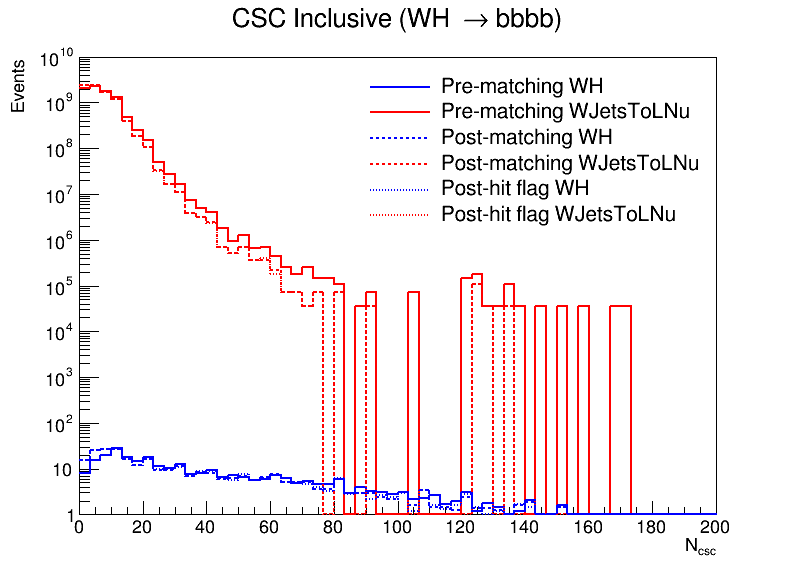

In [176]:
# Creates a 1D histogram of the number of CSC hits for the m50ct1m signal MC, QCD MC, and ZeroBias data 
# with no hit removal

c_match = rt.TCanvas('c_match','c_match', 800, 600)
# h = {}
# h['nCsc_m50ct1m'] = create_TH1D(nCsc['m50ct1m'], axis_title=['nCsc_m50ct1m', 'Events'], name='nCsc_m50ct1m', binning=[150,0,500])
# h['nCsc_m50ct1m'].SetLineColor(4)

h['n_match_m55ct10m_wh_bbbb'] = create_TH1D(nCsc_jetMatch['m55ct10m_wh_bbbb'], axis_title=['n_match_m55ct10m_wh_bbbb', 'Events'], name='n_match_m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['n_match_m55ct10m_wh_bbbb'].SetLineColor(4)
h['n_match_m55ct10m_wh_bbbb'].SetLineStyle(2)

h['n_match_wjets'] = create_TH1D(nCsc_jetMatch['WJetsToLNu'], axis_title=['n_match_wjets', 'Events'], name='n_match_wjets', binning=[150,0,500], weights=weight_WJetsToLNu)
h['n_match_wjets'].SetLineColor(2)
h['n_match_wjets'].SetLineStyle(2)

h['n_noMatch_m55ct10m_wh_bbbb'] = create_TH1D(nCsc['m55ct10m_wh_bbbb'], axis_title=['n_noMatch_m55ct10m_wh_bbbb', 'Events'], name='n_noMatch_m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['n_noMatch_m55ct10m_wh_bbbb'].SetLineColor(4)

h['n_noMatch_wjets'] = create_TH1D(nCsc['WJetsToLNu'], axis_title=['n_noMatch_wjets', 'Events'], name='n_noMatch_wjets', binning=[150,0,500], weights=weight_WJetsToLNu)
h['n_noMatch_wjets'].SetLineColor(2)

h['n_good_m55ct10m_wh_bbbb'] = create_TH1D(nCsc_rechit_jetMatch['m55ct10m_wh_bbbb'], axis_title=['n_good_m55ct10m_wh_bbbb', 'Events'], name='n_good_m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['n_good_m55ct10m_wh_bbbb'].SetLineColor(4)
h['n_good_m55ct10m_wh_bbbb'].SetLineStyle(3)

h['n_good_wjets'] = create_TH1D(nCsc_rechit_jetMatch['WJetsToLNu'], axis_title=['n_good_wjets', 'Events'], name='n_good_wjets', binning=[150,0,500], weights=weight_WJetsToLNu)
h['n_good_wjets'].SetLineColor(2)
h['n_good_wjets'].SetLineStyle(3)


# h['nCsc_zeroBias'] = create_TH1D(nCsc['zeroBias'], axis_title=['nCsc_zeroBias', 'Events'], name='nCsc_zeroBias', binning=[150,0,500])
# h['nCsc_zeroBias'].SetLineColor(2)
# h['nCsc_zeroBias'].SetLineStyle(1)

c_match.SetLogy()

# h['n_match_m55ct10m_wh_bbbb'].Scale(1.0/h['n_match_m55ct10m_wh_bbbb'].Integral())
# h['n_match_wjets'].Scale(1.0/h['n_match_wjets'].Integral())

# h['nCsc_wjets'].Scale(1.0/h['nCsc_wjets'].Integral())
# h['nCsc_zeroBias'].Scale(1.0/h['nCsc_zeroBias'].Integral())


h['n_noMatch_wjets'].SetLineWidth(2)
h['n_match_m55ct10m_wh_bbbb'].SetLineWidth(2)

h['n_match_wjets'].SetLineWidth(2)
h['n_noMatch_m55ct10m_wh_bbbb'].SetLineWidth(2)

h['n_good_wjets'].SetLineWidth(2)
h['n_good_m55ct10m_wh_bbbb'].SetLineWidth(2)

h['n_match_wjets'].GetXaxis().SetRangeUser(0,200)
h['n_match_wjets'].GetYaxis().SetRangeUser(1,10**10)

# h['n_match_wjets'].GetXaxis().SetRangeUser(0,200)
# h['nCsc_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['n_match_wjets'].SetStats(0)
h['n_match_wjets'].SetTitle("CSC Inclusive (WH #rightarrow bbbb)")
h['n_match_wjets'].SetXTitle("N_{csc}")


h['n_match_wjets'].Draw('histo')
# h['nCsc_m50ct1m'].Draw('histo+same')
h['n_match_m55ct10m_wh_bbbb'].Draw('histo+same')
h['n_noMatch_wjets'].Draw('histo+same')
h['n_noMatch_m55ct10m_wh_bbbb'].Draw('histo+same')
h['n_good_wjets'].Draw('histo+same')
h['n_good_m55ct10m_wh_bbbb'].Draw('histo+same')


legend = rt.TLegend(0.45,0.60,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
# legend.SetFillStyle(0);
# legend.AddEntry( h['nCsc_m50ct1m'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['n_noMatch_m55ct10m_wh_bbbb'], "Pre-matching WH" , "L");
legend.AddEntry( h['n_noMatch_wjets'], "Pre-matching WJetsToLNu" , "L");
legend.AddEntry( h['n_match_m55ct10m_wh_bbbb'], "Post-matching WH" , "L");
legend.AddEntry( h['n_match_wjets'], "Post-matching WJetsToLNu" , "L");
legend.AddEntry( h['n_good_m55ct10m_wh_bbbb'], "Post-hit flag WH" , "L");
legend.AddEntry( h['n_good_wjets'], "Post-hit flag WJetsToLNu" , "L");

# legend.AddEntry( h['nCsc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c_match.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

In [196]:
print(np.array(nCsc_station['WJetsToLNu']['ME_12'])[(np.where(np.array(nCsc['WJetsToLNu'])>120)[0])])

[116 102 142   1   2  99 120 117 116 163  97 111   1  96 128 145   1 118
 105 125]


In [188]:
print(len(nCsc_station['WJetsToLNu']['ME_11']))
print(len(nCsc['WJetsToLNu']))

231014
231014


In [175]:
print(len(lumiNum['WJetsToLNu'][(np.where(np.array(nCsc['WJetsToLNu'])>120)[0])]))
print(len(lumiNum['WJetsToLNu'][(np.where(np.array(nCsc_jetMatch['WJetsToLNu'])>120)[0])]))
print(lumiNum['WJetsToLNu'][(np.where(np.array(nCsc_jetMatch['WJetsToLNu'])>120)[0])])
print(eventNum['WJetsToLNu'][(np.where(np.array(nCsc_jetMatch['WJetsToLNu'])>120)[0])])
print(nCsc['WJetsToLNu'][(np.where(np.array(nCsc_jetMatch['WJetsToLNu'])>120)[0])])
print(np.array(nCsc_jetMatch['WJetsToLNu'])[(np.where(np.array(nCsc_jetMatch['WJetsToLNu'])>120)[0])])
print(np.array(nCsc_rechit_jetMatch['WJetsToLNu'])[(np.where(np.array(nCsc_jetMatch['WJetsToLNu'])>120)[0])])

20
6
[117407 114103  49064 196757  33611 207167]
[28880305 28072749 12072622 48397385  8273802 50959418]
[128 124 134 144 124 126]
[128 124 134 144 124 126]
[128 124 134 144 124 126]


In [20]:
fake_pt_csc = {}
fake_mass_csc = {}

print('Start: ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species in data_trees.keys():
    event_empty = np.copy(csc_z[species])*(-999)
    fake_pt_csc[species] = event_empty
    fake_mass_csc[species] = event_empty
    
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-15 02:07:42.740639-07:00
m55ct10m_wh_bbbb_minus: 2019-08-15 02:07:42.744643-07:00
m55ct10m_wh_bbbb_plus: 2019-08-15 02:07:42.748028-07:00
WJetsToLNu: 2019-08-15 02:08:22.412060-07:00


In [21]:
fake_pt_csc['m55ct10m_wh_bbbb'] = np.concatenate([fake_pt_csc['m55ct10m_wh_bbbb_minus'], fake_pt_csc['m55ct10m_wh_bbbb_plus']])
fake_mass_csc['m55ct10m_wh_bbbb'] = np.concatenate([fake_mass_csc['m55ct10m_wh_bbbb_minus'], fake_mass_csc['m55ct10m_wh_bbbb_plus']])

In [29]:
cluster_dataset = {}

print('Start: ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species in data_trees_complete:
    cluster_dataset[species] = np.dstack((fake_pt_csc[species], csc_eta[species], csc_phi[species], fake_mass_csc[species], csc_z[species]))

    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-15 02:31:56.973640-07:00
m55ct10m_wh_bbbb: 2019-08-15 02:31:56.974521-07:00
WJetsToLNu: 2019-08-15 02:32:41.488568-07:00


In [30]:
# Basic implementation: Save pseudojets as [eta, phi, ncsc], remake jet matching to loop over CSC hit clusters instead of CSC hits

In [150]:
csc_clusters = {}
ncsc_cluster = {}

print('Start: ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species in data_trees_complete:
    csc_clusters[species] = []
    ncsc_cluster[species] = []
    for hit_seq in range(len(csc_z[species])):
        test_data_0 = np.dstack(cluster_dataset[species][0][hit_seq])[0].astype(np.float64)
        test_data_0 = np.core.records.fromarrays(test_data_0.transpose(), names='pT, eta, phi, mass, z_pos', formats = 'f8, f8, f8, f8, f8')
        sequence_0 = cluster(test_data_0, R=0.4, p=0)
        jets = sequence_0.inclusive_jets()
        csc_clusters[species].append(jets)
        total_hits = 0
        for cluster_hits in range(len(jets)):
            if len(jets[cluster_hits].constituents_array()) > 3:
                total_hits += len(jets[cluster_hits].constituents_array())
        ncsc_cluster[species].append(total_hits)
    
        if (hit_seq % 1000) == 0:
            print(str(hit_seq) + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    
    print(species + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-16 11:45:01.401260-07:00


NameError: name 'cluster_dataset' is not defined

# Weight Calculation

In [ ]:
# weight_m55ct10m_minus = (5.328 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m55ct10000mm_minus']
# print(weight_m55ct10m_minus)
# print(NEvents['m55ct10000mm_minus'])
# weight_m55ct10m_minus = np.full(len(nCsc['m55ct10m_wh_bbbb_minus']), weight_m55ct10m_minus)
# # weight_m55ct10m_minus = np.full(int(NEvents['m55ct10000mm_minus']), weight_m55ct10m_minus)


# weight_m55ct10m_plus = (8.4 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m55ct10000mm_plus']
# print(weight_m55ct10m_plus)
# print(NEvents['m55ct10000mm_plus'])
# weight_m55ct10m_plus = np.full(len(nCsc['m55ct10m_wh_bbbb_plus']), weight_m55ct10m_plus)
# # weight_m55ct10m_plus = np.full(int(NEvents['m55ct10000mm_plus']), weight_m55ct10m_plus)

# weight_m55ct10m = np.concatenate([weight_m55ct10m_minus, weight_m55ct10m_plus])

# weight_m15ct10m = (5.328 * 10**-1 * 0.324 * 137 * 1000)/NEvents['m15ct10000mm']
# weight_m15ct10m = np.full(len(nCsc['m15ct10m_wh_bbbb']), weight_m15ct10m)

# weight_m40ct10m = (61526.7 * 137 * 1000)/NEvents['m40ct10000mm']
# weight_m40ct10m = np.full(len(nCsc['m40ct10m_wh_bbbb']), weight_m40ct10m)

# weight_WJetsToLNu = (61526.7 * 137 * 1000)/NEvents['WJetsToLNu']
# print(weight_WJetsToLNu)
# print(NEvents['WJetsToLNu'])
# weight_WJetsToLNu = np.full(len(nCsc['WJetsToLNu']), weight_WJetsToLNu)

In [ ]:
# Creates a 1D histogram of the number of CSC hits for the m50ct1m signal MC, QCD MC, and ZeroBias data 
# with no hit removal

c = rt.TCanvas('c','c', 800, 600)
h = {}
# h['nCsc_m50ct1m'] = create_TH1D(nCsc['m50ct1m'], axis_title=['nCsc_m50ct1m', 'Events'], name='nCsc_m50ct1m', binning=[150,0,500])
# h['nCsc_m50ct1m'].SetLineColor(4)

h['m55ct10m_wh_bbbb'] = create_TH1D(nCsc['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb'].SetLineColor(4)

h['m55ct10m_wh_bbbb_cluster'] = create_TH1D(ncsc_cluster['m55ct10m_wh_bbbb'], axis_title=['m55ct10m_wh_bbbb_cluster', 'Events'], name='m55ct10m_wh_bbbb_cluster', binning=[150,0,500], weights = weight_m55ct10m)
h['m55ct10m_wh_bbbb_cluster'].SetLineColor(4)
h['m55ct10m_wh_bbbb_cluster'].SetLineStyle(2)

h['nCsc_wjets'] = create_TH1D(nCsc['WJetsToLNu'], axis_title=['nCsc_wjets', 'Events'], name='nCsc_wjets', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets'].SetLineColor(2)

h['nCsc_wjets_cluster'] = create_TH1D(ncsc_cluster['WJetsToLNu'], axis_title=['nCsc_wjets_cluster', 'Events'], name='nCsc_wjets_cluster', binning=[150,0,500], weights = weight_WJetsToLNu)
h['nCsc_wjets_cluster'].SetLineColor(2)
h['nCsc_wjets_cluster'].SetLineStyle(2)

c.SetLogy()

h['m55ct10m_wh_bbbb'].SetLineWidth(2)
h['m55ct10m_wh_bbbb_cluster'].SetLineWidth(2)

h['nCsc_wjets'].SetLineWidth(2)
h['nCsc_wjets_cluster'].SetLineWidth(2)

# h['nCsc_m50ct1m'].GetXaxis().SetRangeUser(0,200)
h['nCsc_wjets'].GetYaxis().SetRangeUser(1,10**10)

h['nCsc_wjets'].GetXaxis().SetRangeUser(0,225)
# h['nCsc_zeroBias'].GetXaxis().SetRangeUser(0,200)


h['nCsc_wjets'].SetStats(0)
h['nCsc_wjets'].SetTitle("CSC Inclusive (WH #rightarrow bbbb)")
h['nCsc_wjets'].SetXTitle("N_{csc}")


h['nCsc_wjets'].Draw('histo')
# h['nCsc_m50ct1m'].Draw('histo+same')
h['m55ct10m_wh_bbbb'].Draw('histo+same')
h['nCsc_wjets_cluster'].Draw('histo+same')
h['m55ct10m_wh_bbbb_cluster'].Draw('histo+same')

# h['nCsc_zeroBias'].Draw('histo+same')

legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
# legend.SetFillStyle(0);
# legend.AddEntry( h['nCsc_m50ct1m'], "mX=50 GeV, c#tau=1m (MC)" , "L");
legend.AddEntry( h['m55ct10m_wh_bbbb'], "Signal w/o clustering" , "L");
legend.AddEntry( h['nCsc_wjets'], "Bkg w/o clustering" , "L");
legend.AddEntry( h['m55ct10m_wh_bbbb_cluster'], "Signal with clustering" , "L");
legend.AddEntry( h['nCsc_wjets_cluster'], "Bkg with clustering" , "L");
# legend.AddEntry( h['nCsc_zeroBias'], "Zero Bias" , "L");

legend.Draw();

c.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

In [ ]:
# print(np.dstack(cluster_dataset['m55ct10m_wh_bbbb'][0][5001])[0])
test_data_5001 = np.dstack(cluster_dataset['m55ct10m_wh_bbbb'][0][0])[0].astype(np.float64)
test_data_5001 = np.core.records.fromarrays(test_data_5001.transpose(), names='pT, eta, phi, mass', formats = 'f8, f8, f8, f8')
# print(test_data_5001)
sequence_5001 = cluster(test_data_5001, R=0.4, p=0)
jets = sequence_5001.inclusive_jets()
print(jets)
# for constit in jets[0]:
#     print(constit)
# print(jets[0].constituents_array())

In [ ]:
# k-means clustering algorithm
# For more information, check out https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids) and iterations > 0


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, i):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    
    #print dist
    if i < 1:
        dist[dist>1.0] = 999
    elif i < 2:
        dist[dist>0.8] = 999
    else:
        dist[dist>0.4] = 999
        
    #print dist
    #print np.argmin(dist, axis=1)
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids_kmeans(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.average(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids():
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    even_list = np.linspace(-4.0, 4.0, num=5)
    centers  = np.empty((0,2))
    for i in even_list:
        for j in even_list:
            #print i,j
            new_arr = np.array([i,j])
            centers = np.append(centers,[new_arr],axis=0)
    #print centers
    return centers
    #return np.mgrid[-4:4.1:2, -4:4.1:2].reshape(2,-1).T
    #return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids_kmeans(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

####################################################################################################

# k-medians Algorithm
# -------------
# k-medians is equivalent algorithm to k-means except it calculates the median instead of the average

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids_kmedians(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.median(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric median of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.

# Function: K Medians
# -------------
# K-medians is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmedians(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids_kmeans(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

In [ ]:
evt_idx = 0

c_cluster = rt.TCanvas('c_cluster','c_cluster', 800, 600)
h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta['m55ct10m_wh_bbbb'][evt_idx],csc_phi['m55ct10m_wh_bbbb'][evt_idx])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])

## Scrapped due to np.logical_and discovery
# Resulting implementation of eventNum
#h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta_dis[event4][0],csc_phi_dis[event4][0])).T, name='eta_phi_0', title='', binning=[80, -4, 4, 80, -4, 4], weights=None, axis_title = ['#eta','#phi', ''])


c_cluster.SetLogy(0)
h['eta_phi_0'].SetStats(0)
c_cluster.cd()
#h['eta_phi_0'].SetStats(0)
h['eta_phi_0'].Draw("colz")


#test_dataset = np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T

test_dataset = np.vstack((csc_eta['m55ct10m_wh_bbbb'][evt_idx],csc_phi['m55ct10m_wh_bbbb'][evt_idx])).T
#print(test_dataset)
#print test_dataset.ndim
#print len(csc_eta_prompt[evt_idx])
centroids_t,centroid_constituents_t = kmeans(test_dataset,25)
print(centroids_t)

ll = 0
xx = []
yy = []
nn = 0
for nc in centroid_constituents_t:
    if nc > 0:
        nn += 1
        xx.append(centroids_t[ll,0])
        yy.append(centroids_t[ll,1])
    ll += 1


tg = rt.TGraph(nn)
for ii in range(nn):
    tg.SetPoint(ii,xx[ii],yy[ii])
    print(xx[ii],yy[ii])


tg.SetMarkerSize(3)
tg.SetMarkerStyle(28)
tg.Draw("P0+same")


c_cluster.Draw()

In [ ]:
# ROC Curve for ggH/QCD/ZeroBias Samples: nCsc 

eff_ncsc = {}
rejection_power = {}
ncsc_var_x = np.array([])

for data_type in data_trees.keys():
    eff_ncsc[data_type] = {}
    
    eff_ncsc[data_type]['cluster'] = {}
    eff_ncsc[data_type]['cluster']['csc_inclusive'] = np.array([])
    eff_ncsc[data_type]['cluster']['csc_noME11'] = np.array([])
    eff_ncsc[data_type]['cluster']['csc_noME112'] = np.array([])
    eff_ncsc[data_type]['cluster']['csc_noME1123'] = np.array([])
    
    eff_ncsc[data_type]['noCluster'] = {}
    eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.array([])
    eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.array([])
    
    eff_ncsc[data_type]['matching'] = {}
    eff_ncsc[data_type]['matching']['csc_inclusive'] = np.array([])
    
    for hit_thresh in range(0, 200):
        ncsc_var_x = np.append(ncsc_var_x, hit_thresh)
        # Clustering ROCs
        eff_ncsc[data_type]['cluster']['csc_inclusive'] = np.append(eff_ncsc[data_type]['cluster']['csc_inclusive'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_inclusive'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_inclusive']))
        eff_ncsc[data_type]['cluster']['csc_noME11'] = np.append(eff_ncsc[data_type]['cluster']['csc_noME11'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_noME11'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_noME11']))
        eff_ncsc[data_type]['cluster']['csc_noME112'] = np.append(eff_ncsc[data_type]['cluster']['csc_noME112'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_noME112'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_noME112']))
        eff_ncsc[data_type]['cluster']['csc_noME1123'] = np.append(eff_ncsc[data_type]['cluster']['csc_noME1123'], np.count_nonzero(np.array(nCsc_cluster[data_type]['csc_noME1123'])>hit_thresh)/len(nCsc_cluster[data_type]['csc_noME1123']))

       # No-Clustering ROCs
        eff_ncsc[data_type]['noCluster']['csc_inclusive'] = np.append(eff_ncsc[data_type]['noCluster']['csc_inclusive'], np.count_nonzero(np.array(nCsc[data_type])>hit_thresh)/len(nCsc[data_type]))
        eff_ncsc[data_type]['noCluster']['csc_noME11'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME11'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_11'])>hit_thresh)/len(nCsc_removal[data_type]['ME_11']))
        eff_ncsc[data_type]['noCluster']['csc_noME112'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME112'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_112'])>hit_thresh)/len(nCsc_removal[data_type]['ME_112']))
        eff_ncsc[data_type]['noCluster']['csc_noME1123'] = np.append(eff_ncsc[data_type]['noCluster']['csc_noME1123'], np.count_nonzero(np.array(nCsc_removal[data_type]['ME_1123'])>hit_thresh)/len(nCsc_removal[data_type]['ME_1123']))
    
        # Matching ROCs
        eff_ncsc[data_type]['matching']['csc_inclusive'] = np.append(eff_ncsc[data_type]['matching']['csc_inclusive'], np.count_nonzero(np.array(nCsc_jetMatch[data_type])>hit_thresh)/len(nCsc_jetMatch[data_type]))
        
        print(str(hit_thresh) + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
        
    # Rejection power calculation
    rejection_power[data_type] = {}
    rejection_power[data_type]['cluster'] = {}
    rejection_power[data_type]['noCluster'] = {}
    rejection_power[data_type]['matching'] = {}
    
    # Clustering
    rejection_power[data_type]['cluster']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_inclusive']))
    rejection_power[data_type]['cluster']['csc_noME11'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_noME11']))
    rejection_power[data_type]['cluster']['csc_noME112'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_noME112']))
    rejection_power[data_type]['cluster']['csc_noME1123'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['cluster']['csc_noME1123']))
    # No clustering
    rejection_power[data_type]['noCluster']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_inclusive']))
    rejection_power[data_type]['noCluster']['csc_noME11'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME11']))
    rejection_power[data_type]['noCluster']['csc_noME112'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME112']))
    rejection_power[data_type]['noCluster']['csc_noME1123'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['noCluster']['csc_noME1123']))
    # Matching
    rejection_power[data_type]['matching']['csc_inclusive'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['matching']['csc_inclusive']))
    
    print(data_type + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

In [ ]:
eff_ncsc['m55ct10m_wh_bbbb'] = {}
for llave in eff_ncsc['m55ct10m_wh_bbbb_minus'].keys():
    eff_ncsc['m55ct10m_wh_bbbb'][llave] = {}
    for cle in eff_ncsc['m55ct10m_wh_bbbb_minus'][llave].keys():
        eff_ncsc['m55ct10m_wh_bbbb'][llave][cle] = np.concatenate([eff_ncsc['m55ct10m_wh_bbbb_minus'][llave][cle], eff_ncsc['m55ct10m_wh_bbbb_plus'][llave][cle]])

In [ ]:
# ROC Curves to make
# Out of the box: CSC inclusive, no clustering, no matching
# Simple cut: ME 1/2 + 1/2 hits removed, no clustering, no matching
# FastJet cut: ME 1/2 + 1/2 hits removed, FastJet clustering, no matching
# kmeans cut: ME 1/2 + 1/2 hits removed, kmeans clustering, no matching
# Matching cut: No station hits removed, no clustering, matching
# Final cut: No station hits removed, FastJet clustering, matching

In [ ]:
# Creates ROC curves for the signal efficiency of the m50ct1m signal sample against the ZeroBias samples
# using nCsc thresholds

c3 = rt.TCanvas('c3','c3', 800, 600)

h['roc_curve_noCluster'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_inclusive'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_clean_noCluster'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_noME11'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_noME11'], axis_title=['#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_res_noCluster'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_noME1123'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_noME1123'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_med_noCluster'] = create_TGraph(rejection_power['WJetsToLNu']['noCluster']['csc_noME112'], eff_ncsc['m55ct10m_wh_bbbb']['noCluster']['csc_noME112'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_matching'] = create_TGraph(rejection_power['WJetsToLNu']['matching']['csc_inclusive'], eff_ncsc['m55ct10m_wh_bbbb']['matching']['csc_inclusive'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])


c3.SetLogx()

h['roc_curve_noCluster'].SetTitle('WJetsToLNu')


h['roc_curve_noCluster'].SetLineWidth(2)
h['roc_curve_clean_noCluster'].SetLineWidth(2)
h['roc_curve_res_noCluster'].SetLineWidth(2)
h['roc_curve_med_noCluster'].SetLineWidth(2)
h['roc_curve_matching'].SetLineWidth(2)

h['roc_curve_noCluster'].SetLineColor(1)
h['roc_curve_noCluster'].SetLineStyle(2)

h['roc_curve_matching'].SetLineColor(6)
h['roc_curve_matching'].SetLineStyle(1)

h['roc_curve_clean_noCluster'].SetLineColor(2)
h['roc_curve_clean_noCluster'].SetLineStyle(2)
                                          
h['roc_curve_res_noCluster'].SetLineColor(3)
h['roc_curve_res_noCluster'].SetLineStyle(2)

h['roc_curve_med_noCluster'].SetLineColor(4)
h['roc_curve_med_noCluster'].SetLineStyle(2)

h['roc_curve_noCluster'].GetXaxis().SetLimits(10, 10**4)
h['roc_curve_noCluster'].GetYaxis().SetRangeUser(0,1)

h['roc_curve_noCluster'].Draw()
h['roc_curve_clean_noCluster'].Draw('same')

h['roc_curve_res_noCluster'].Draw('same')
h['roc_curve_med_noCluster'].Draw('same')
h['roc_curve_matching'].Draw('same')

legend = rt.TLegend(0.70,0.70,0.7,0.7);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.SetFillStyle(0);

legend.AddEntry( h['roc_curve_noCluster'], "Inclusive", 'l');
legend.AddEntry( h['roc_curve_clean_noCluster'], "No 1/1", 'l');
legend.AddEntry( h['roc_curve_med_noCluster'], "No 1/1+1/2", 'l');
legend.AddEntry( h['roc_curve_res_noCluster'], "No 1/1+1/2+1/3", 'l');
legend.AddEntry( h['roc_curve_matching'], "Matched Hits Removed", 'l');


legend.Draw();

c3.Draw()